In [7]:
import os
import sys
# CaLRepo = os.environ.get("CaLRepo")
CaLRepo ='/home/zyq0416/workspace/CaL'
# print(CaLRepo)
sys.path.append(f"{CaLRepo}/utilities/")

import numpy as np
import pandas as pd
import proplot as pplot
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
import json

from pyBrayton import Brayton

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'B_initialvalue': {'isentropic_eff_mc': 0.88, 'mechanical_eff': 0.98, 'min_temperature_exchange': 15, 'industrial_waste_heat_t': 300, 't_reaction': 465, 'p_bray_H': 20000000.0, 'p_bray_M': 13000000.0, 'p_bray_L': 7600000.0}, 'B_primary_turbine': {'t_turbine_out': 399.47232190468196, 'p_turbine_out': 13000000.0, 'h_turbine_out': 859339.0028423991, 's_turbine_out': 2588.140448388767, 'power_turbine': 51416.15119357573, 'e_lost_turbine': 1049.3092080321803}, 'secondary_h_exchanger': {'t_h_exchanger_out': 450, 'p_h_exchanger_out': 13000000.0, 'h_h_exchanger_out': 919578.7863531199, 's_h_exchanger_out': 2674.4914142288467, 'hot_out_h_exchanger': -60239.78354215284}, 'B_secondary_turbine': {'t_turbine_out': 388.9301578161062, 'p_turbine_out': 7600000.0, 'h_turbine_out': 855182.8904548262, 's_turbine_out': 2682.9802246397367, 'power_turbine': 63107.9779803278, 'e_lost_turbine': 1287.917917965904}, 'High_h_recovery': {'t_h_recovery_hh_out': 363.777922908414, 'p_h_recovery_hh_out': 20000000.0,

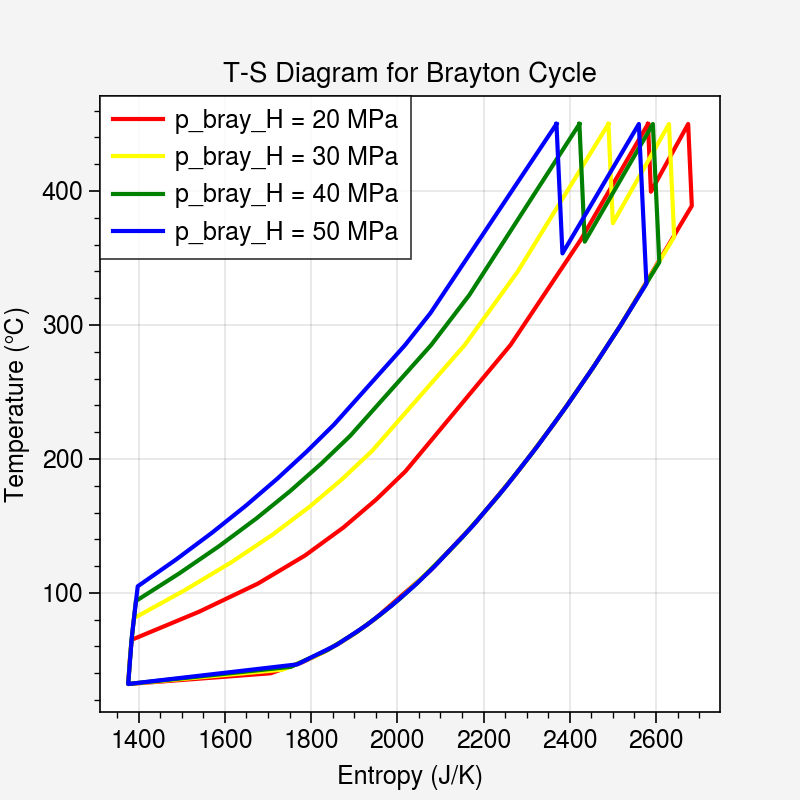

In [8]:
parameters = dict() 
flue_gas_composistion = dict()
flue_gas_composistion["co2"] = 0.1338
flue_gas_composistion["o2"] = 0.0384
flue_gas_composistion["n2"] = 0.6975
parameters["flue_gas_composition"] = flue_gas_composistion
parameters["isentropic_eff_mc"] = 0.88  #等熵效率
parameters["t_isentropic_eff_mc"] = 0.92
parameters["mechanical_eff"] = 0.98   #机械效率
parameters["min_temperature_exchange"] = 15
parameters["industrial_waste_heat_t"] =300 #℃
parameters["heat_transfer_loss_eff"] = 0.96
parameters["t_reaction"] = 465
#parameters["p_bray_H"] = 20e6
#parameters["p_bray_M"] = 14e6
parameters["p_bray_L"] = 7.6e6
parameters["T_amb"] = 20
parameters["p_amb"] = 101325
p_bray_H_values = [20e6, 30e6, 40e6,50e6]
p_bray_M_values = [13e6, 16e6, 19e6,22e6]
colors = ['red', 'yellow', 'green','blue']  
labels = ['p_bray_H = 20 MPa', 'p_bray_H = 30 MPa', 'p_bray_H = 40 MPa','p_bray_H = 50 MPa'] 
for i, (p_bray_H, p_bray_M) in enumerate(zip(p_bray_H_values, p_bray_M_values)):
    # Set the p_bray_H value in parameters dictionary
    parameters["p_bray_H"] = p_bray_H
    parameters["p_bray_M"] = p_bray_M
    Bray = Brayton(parameters)
    Hydrator_heat=1376678.4 #1.38MW
    results = Bray.solve(Hydrator_heat)
    print(results)
    T1=results["primary_h_exchanger"]["t_h_exchanger_out"]
    S1=results["primary_h_exchanger"]["s_h_exchanger_out"]
    T2=results["B_primary_turbine"]["t_turbine_out"]
    S2=results["B_primary_turbine"]["s_turbine_out"]
    T3=results["secondary_h_exchanger"]["t_h_exchanger_out"]
    S3=results["secondary_h_exchanger"]["s_h_exchanger_out"]
    T4=results["B_secondary_turbine"]["t_turbine_out"]
    S4=results["B_secondary_turbine"]["s_turbine_out"]
    T5=results["Low_h_recovery"]["t_h_recovery_ll_in"]
    S5=results["Low_h_recovery"]["s_h_recovery_ll_in"]
    T6=results["cooling_tower"]["t_cooling_tower_in"]
    S6=results["cooling_tower"]["s_cooling_tower_in"]
    T7=results["cooling_tower"]["t_cooling_tower_out"]
    S7=results["cooling_tower"]["s_cooling_tower_out"]
    T8=results["B_primary_compressor"]["t_compressor_out"]
    S8=results["B_primary_compressor"]["s_compressor_out"]
    T9=results["B_secondary_compressor"]["t_compressor_out"]
    S9=results["B_secondary_compressor"]["s_compressor_out"]
    T10=results["Low_h_recovery"]["t_h_recovery_hh_out"]
    S10=results["Low_h_recovery"]["s_h_recovery_hh_out"]
    T11=results["heat_recovery"]["t_heat_recovery_out"]
    S11=results["heat_recovery"]["s_heat_recovery_out"]
    T12=results["High_h_recovery"]["t_h_recovery_hh_out"]
    S12=results["High_h_recovery"]["s_h_recovery_hh_out"]
    points = [(S1, T1), (S2, T2), (S3, T3), (S4, T4), (S5, T5),
            (S6, T6), (S7, T7), (S8, T8), (S9, T9),(S10, T10),
            (S11, T11), (S12, T12),]
    num_insertions = 5  # 插入的温度点数量
    P_CO2_7p6 = 7.6e6  # 7.6 MPa下的压力
    P_CO2_20 = parameters["p_bray_H"]  # 20 MPa下的压力

    # 在T5-T6之间插入温度点并计算对应的S值
    T_5_6_points = [points[4][1] + i * (points[5][1] - points[4][1]) / (num_insertions + 1) for i in range(1, num_insertions + 1)]
    S_5_6_points = [CP.PropsSI("S", "P", P_CO2_7p6, "T", T+273.15, "CO2") for T in T_5_6_points]

    # 在T6-T7之间插入温度点并计算对应的S值
    T_6_7_points = [points[5][1] + i * (points[6][1] - points[5][1]) / (num_insertions + 1) for i in range(1, num_insertions + 1)]
    S_6_7_points = [CP.PropsSI("S", "P", P_CO2_7p6, "T", T+273.15, "CO2") for T in T_6_7_points]

    # 在T9-T10之间插入温度点并计算对应的S值
    T_9_10_points = [points[8][1] + i * (points[9][1] - points[8][1]) / (num_insertions + 1) for i in range(1, num_insertions + 1)]
    S_9_10_points = [CP.PropsSI("S", "P", P_CO2_20, "T", T+273.15, "CO2") for T in T_9_10_points]

    # 将新的温度点和对应的S值插入到points列表中的对应位置
    points = points[:5] + list(zip(S_5_6_points, T_5_6_points)) + points[5:6] + list(zip(S_6_7_points, T_6_7_points)) + points[6:9] + list(zip(S_9_10_points, T_9_10_points)) + points[9:]

    # 添加第一个点到最后，形成闭合图像
    points.append(points[0])

    # 提取S和T的值
    S = [point[0] for point in points]
    T = [point[1] for point in points]
    
    # 绘制图像
    # 在每个点旁边添加数据T
    #for i, point in enumerate(points):
        #plt.annotate(str(point[1]), (point[0], point[1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.plot(S, T, color=colors[i], label=labels[i])
plt.legend()
plt.xlabel('Entropy (J/K)')
plt.ylabel('Temperature (℃)')
plt.title('T-S Diagram for Brayton Cycle')

# Show the plot
plt.show()